# Description

Somewhat cleaner notebook for exploring learning IVs, in the linear case.

# Imports

In [203]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact_manual, IntSlider, FloatSlider
from sklearn.linear_model import LinearRegression
from linearmodels.iv.model import IV2SLS

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

from econml.grf import RegressionForest

# Setup: linear treatment effects

We take a classic linear regression setup, where the treatment is correlated with some confounder $C$:

$$
Y = \beta + \tau T + \gamma C + \epsilon, \;\; Cov(T,C) \neq 0
$$

The estimand of interest is $\tau$, the treatment effect.

We then have an instrumental variable $Z$ such that:

$$
T = \pi Z + \psi C + \eta, \;\; Cov(Z,C) = 0
$$

In [146]:
def generate_const_linear_iv(
    n_samples,
    seed,
    pi,
    psi,
    tau,
    gamma
):
    """
    Generates linear IV with constant treatment effects.
    
    Args:
        n_samples (int): num samples to generate
        seed (int): seed for reproducibilty
        pi (float): instrument "strength"
        psi (float): confounding "strength"
        tau (float): treatment effect
        gamma (float): confound effect
    
    Returns:
        pd.DataFrame
    """
    np.random.seed(seed),
    Z = np.random.normal(0, 1, size=n_samples)#np.random.uniform(0, 10, n_samples)
    C = np.random.normal(0, 1, size=n_samples)#np.random.uniform(0, 10, n_samples)
    eta = np.random.normal(0, 1, size=n_samples)
    const = np.random.uniform(-1, 1)

    T = const + (pi*Z) + (psi*C) + eta

    epsilon = np.random.normal(0, 1, size=n_samples)
    beta = np.random.uniform(-1, 1)

    Y = beta + (tau*T) + (gamma*C) + epsilon

    data = np.concatenate([Z.reshape(-1,1), 
                           C.reshape(-1,1), 
                           T.reshape(-1,1),
                           Y.reshape(-1,1),], 
                         axis=1)

    data_df = pd.DataFrame(data, columns=['Z', 'C', 'T', 'Y'])

    return data_df


In [154]:
# generate IV data

# consts
n_samples = 1000
seed = 42
pi = 1 # IV "strength"
psi = 5 # confound "strength"

tau = 2 # treat effect
gamma = -5 # confound effect

df = generate_const_linear_iv(
        n_samples,
        seed,
        pi,
        psi,
        tau,
        gamma)

df

Z         C         T         Y
0    0.496714  1.399355  7.455794  8.165450
1   -0.138264  0.924634  4.977866  6.099834
2    0.647689  0.059630  0.790901  1.169550
3    1.523030 -0.646937 -1.382135  0.640969
4   -0.234153  0.698223  2.000829  0.956657
..        ...       ...       ...       ...
995 -0.281100  1.070150  5.784612  6.625270
996  1.797687 -0.026521  2.560313  5.047941
997  0.640843 -0.881875 -4.372811 -3.512755
998 -0.571179 -0.163067 -0.414857  0.175355
999  0.572583 -0.744903 -2.669709 -2.124274

[1000 rows x 4 columns]

(-10.0, 10.0)

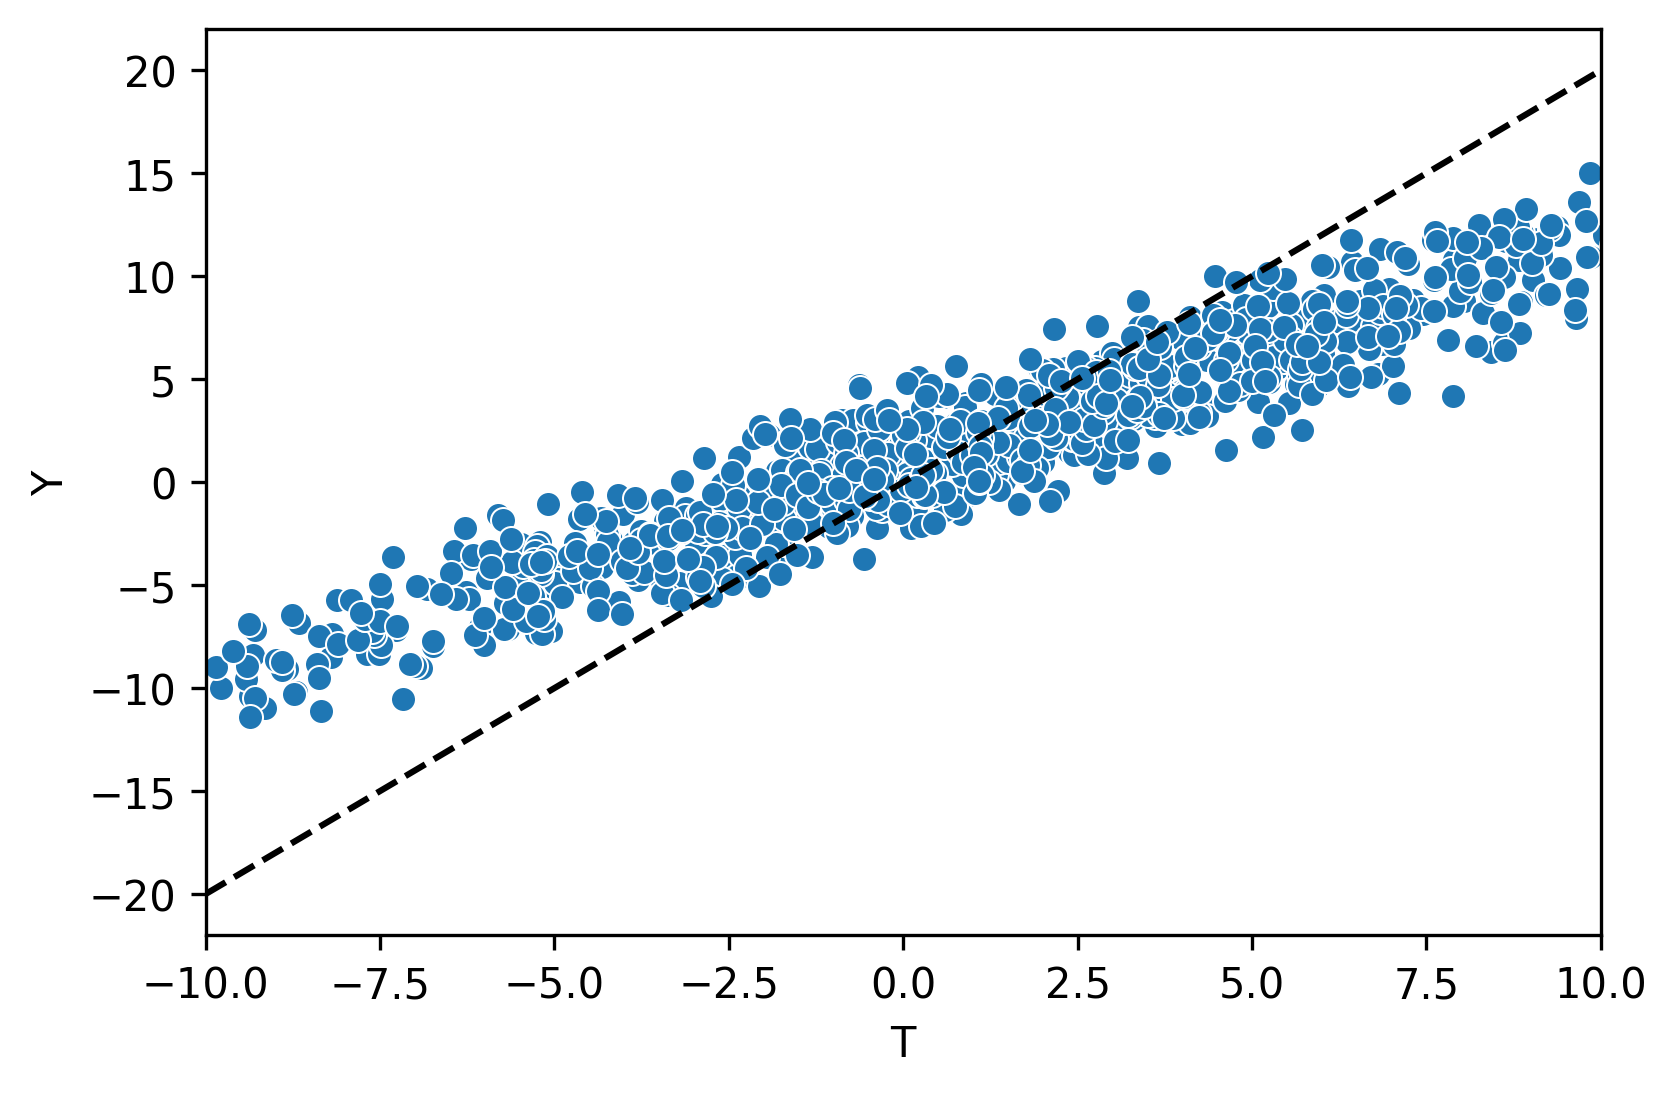

In [155]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-10,10, 20), 2*np.linspace(-10,10,20), ls='--', color='black')
sns.scatterplot(x='T', y='Y', data=df, ax=ax)
ax.set_xlim(-10,10)

In [156]:
feat_cols = [
    "mean_Z",
    "mean_T",
    "mean_Y",
    "var_Z",
    "var_T",
    "var_Y",
    "cov_ZT",
    "cov_ZY",
    "cov_TY",
    "n"
]

def generate_iv_features(data_df, confounder='C'):
    """Generates IV features from a given simple (four variable) data matrix."""
    
    data = data_df.drop(confounder, axis='columns', errors='ignore')   
    data = data[["Z", "T", "Y"]]
    
    cov_mat = np.cov(data, rowvar=False)

    var = np.diag(cov_mat).reshape(-1)
    var = var[var != 0]
    
    cov = np.array([cov_mat[0,1], cov_mat[0,2], cov_mat[1,2]])
    mean = np.mean(data).values

    feats = np.concatenate([mean, var, cov, np.array(data_df.shape[0]).reshape(-1)])

    return pd.DataFrame(feats.reshape(1, -1), columns=feat_cols)

In [150]:
feat_df = generate_iv_features(data_df)

## Full simulations: varying IV strength

### Regression, TSLS 

In [189]:
iv_strs = np.round(np.linspace(.1, .9, 9), 2) #np.round(np.linspace(0.1, 0.9, 9), 2)
n_datasets = 10000
n_test_datasets = 2000

#n_samples = 1000
psi = 5 # confound "strength"

iv_mses = []
reg_mses = []

iv_stderrs = []
iv_preds = []
reg_preds = []

for pi in tqdm(iv_strs):
    print(pi)
    lin_reg_taus = np.zeros(n_test_datasets)
    tsls_taus = np.zeros(n_test_datasets)
    tsls_stderrs = np.zeros(n_test_datasets)
    test_taus = np.zeros(n_test_datasets)

    for i in range(n_test_datasets):
        seed = i + int(pi*10000) # to ensure we have non-overlapping datasets
        
        treat_effect = np.random.uniform(-2, 2)
        confound_effect = np.random.uniform(1, 5)
        n_samples = 1000
        #n_samples = int(np.random.uniform(500, 5000))
        
        data_df = generate_const_linear_iv(
            n_samples=n_samples,
            seed=seed,
            pi=pi,
            psi=psi,
            tau=treat_effect,
            gamma=confound_effect)
        
        lin_reg = LinearRegression()

        lin_reg.fit(data_df['T'].values.reshape(-1,1), data_df['Y'])
        tsls = IV2SLS.from_formula('Y ~ 1 + [T ~ Z]',
                                   data=data_df)    
        iv_res = tsls.fit()
        
        lin_reg_taus[i] = lin_reg.coef_[0]
        tsls_taus[i] = iv_res.params['T']
        tsls_stderrs[i] = iv_res.std_errors['T']

        test_taus[i] = treat_effect
        #break
    iv_preds.append(tsls_taus)
    iv_stderrs.append(tsls_stderrs)
    reg_preds.append(lin_reg_taus)
        
    iv_mses.append(mse(tsls_taus, test_taus))
    reg_mses.append(mse(lin_reg_taus, test_taus))
    #break

  0%|          | 0/9 [00:00<?, ?it/s]

0.1


 11%|█         | 1/9 [00:30<04:00, 30.05s/it]

0.2


 22%|██▏       | 2/9 [01:01<03:36, 30.86s/it]

0.3


 33%|███▎      | 3/9 [01:36<03:17, 32.84s/it]

0.4


 44%|████▍     | 4/9 [02:07<02:39, 31.96s/it]

0.5


 56%|█████▌    | 5/9 [02:45<02:17, 34.32s/it]

0.6


 67%|██████▋   | 6/9 [03:24<01:47, 35.85s/it]

0.7


 78%|███████▊  | 7/9 [04:04<01:14, 37.06s/it]

0.8


 89%|████████▉ | 8/9 [04:51<00:40, 40.21s/it]

0.9


100%|██████████| 9/9 [05:29<00:00, 36.57s/it]


In [190]:
reg_mses

[0.3810655667171604,
 0.38194743396293335,
 0.37573755086050675,
 0.3767699181778845,
 0.3818413208454034,
 0.37119073675606123,
 0.36654485416075716,
 0.3616157366344397,
 0.36096780530265415]

In [191]:
iv_mses

[36.59880781733992,
 48.989512656954965,
 114.80431460634696,
 15.505049091423551,
 1.765740062963041,
 3.4483780032614884,
 0.057282117072752194,
 0.02754227095001888,
 0.020886317700217188]

### Features for supervised learning

In [216]:
ml_mses = []
ml_preds = []

wald_preds = []
wald_mses = []

test_taus = []
test_feats = []
test_stderrs = []
feat_importances = []

n_datasets = 10000
n_test_datasets = 2000

for pi in tqdm(iv_strs):
    data = np.zeros((n_datasets, 10))
    taus = np.zeros(n_datasets)
    confounds = np.zeros(n_datasets)
    
    for i in range(n_datasets):
        seed = i + int(pi*10000) # to ensure we have non-overlapping datasets
        
        treat_effect = np.random.uniform(-2, 2)
        confound_effect = np.random.uniform(1, 5)
        n_samples = 1000
        
        data_df = generate_const_linear_iv(
            n_samples=n_samples,
            seed=seed,
            pi=pi,
            psi=psi,
            tau=treat_effect,
            gamma=confound_effect)
        
        feats = generate_iv_features(data_df)
        data[i,:] = feats
        taus[i] = treat_effect
        confounds[i] = confound_effect
        
    X_train = data[n_test_datasets:, :]
    X_test = data[:n_test_datasets, :]

    y_train = taus[n_test_datasets:]
    y_test = taus[:n_test_datasets]
    
    meta_learner = RegressionForest(random_state=42, n_estimators=100)
    meta_learner.fit(X_train, y_train)
    
    preds = meta_learner.predict(X_test)
    std_err = meta_learner.prediction_stderr(X_test)
    
    #        Cov(Z,Y)       Cov(T,Z)
    wald = X_test[:, 7] / X_test[:, 6]
    wald_preds.append(wald)
    
    ml_preds.append(preds)
    test_taus.append(y_test)
    test_feats.append(X_test)
    test_stderrs.append(std_err)
    
    feat_importances.append(meta_learner.feature_importances_)
    ml_mses.append(mse(preds, y_test))
    wald_mses.append(mse(wald, y_test))

100%|██████████| 9/9 [06:57<00:00, 46.39s/it]


In [217]:
ml_mses

[0.040290423090623924,
 0.03307301856012415,
 0.023366116934690682,
 0.018143214072490036,
 0.013856752460862778,
 0.011282160768670889,
 0.009995515070881762,
 0.006748124395012492,
 0.005803639851457666]

In [218]:
wald_mses

[36.59892307525439,
 48.98986831811376,
 114.80431457877887,
 15.505049974308852,
 1.7657393379757054,
 3.4483438673586346,
 0.05722387862175021,
 0.02754135381048877,
 0.020885734452430794]

(4, 3)


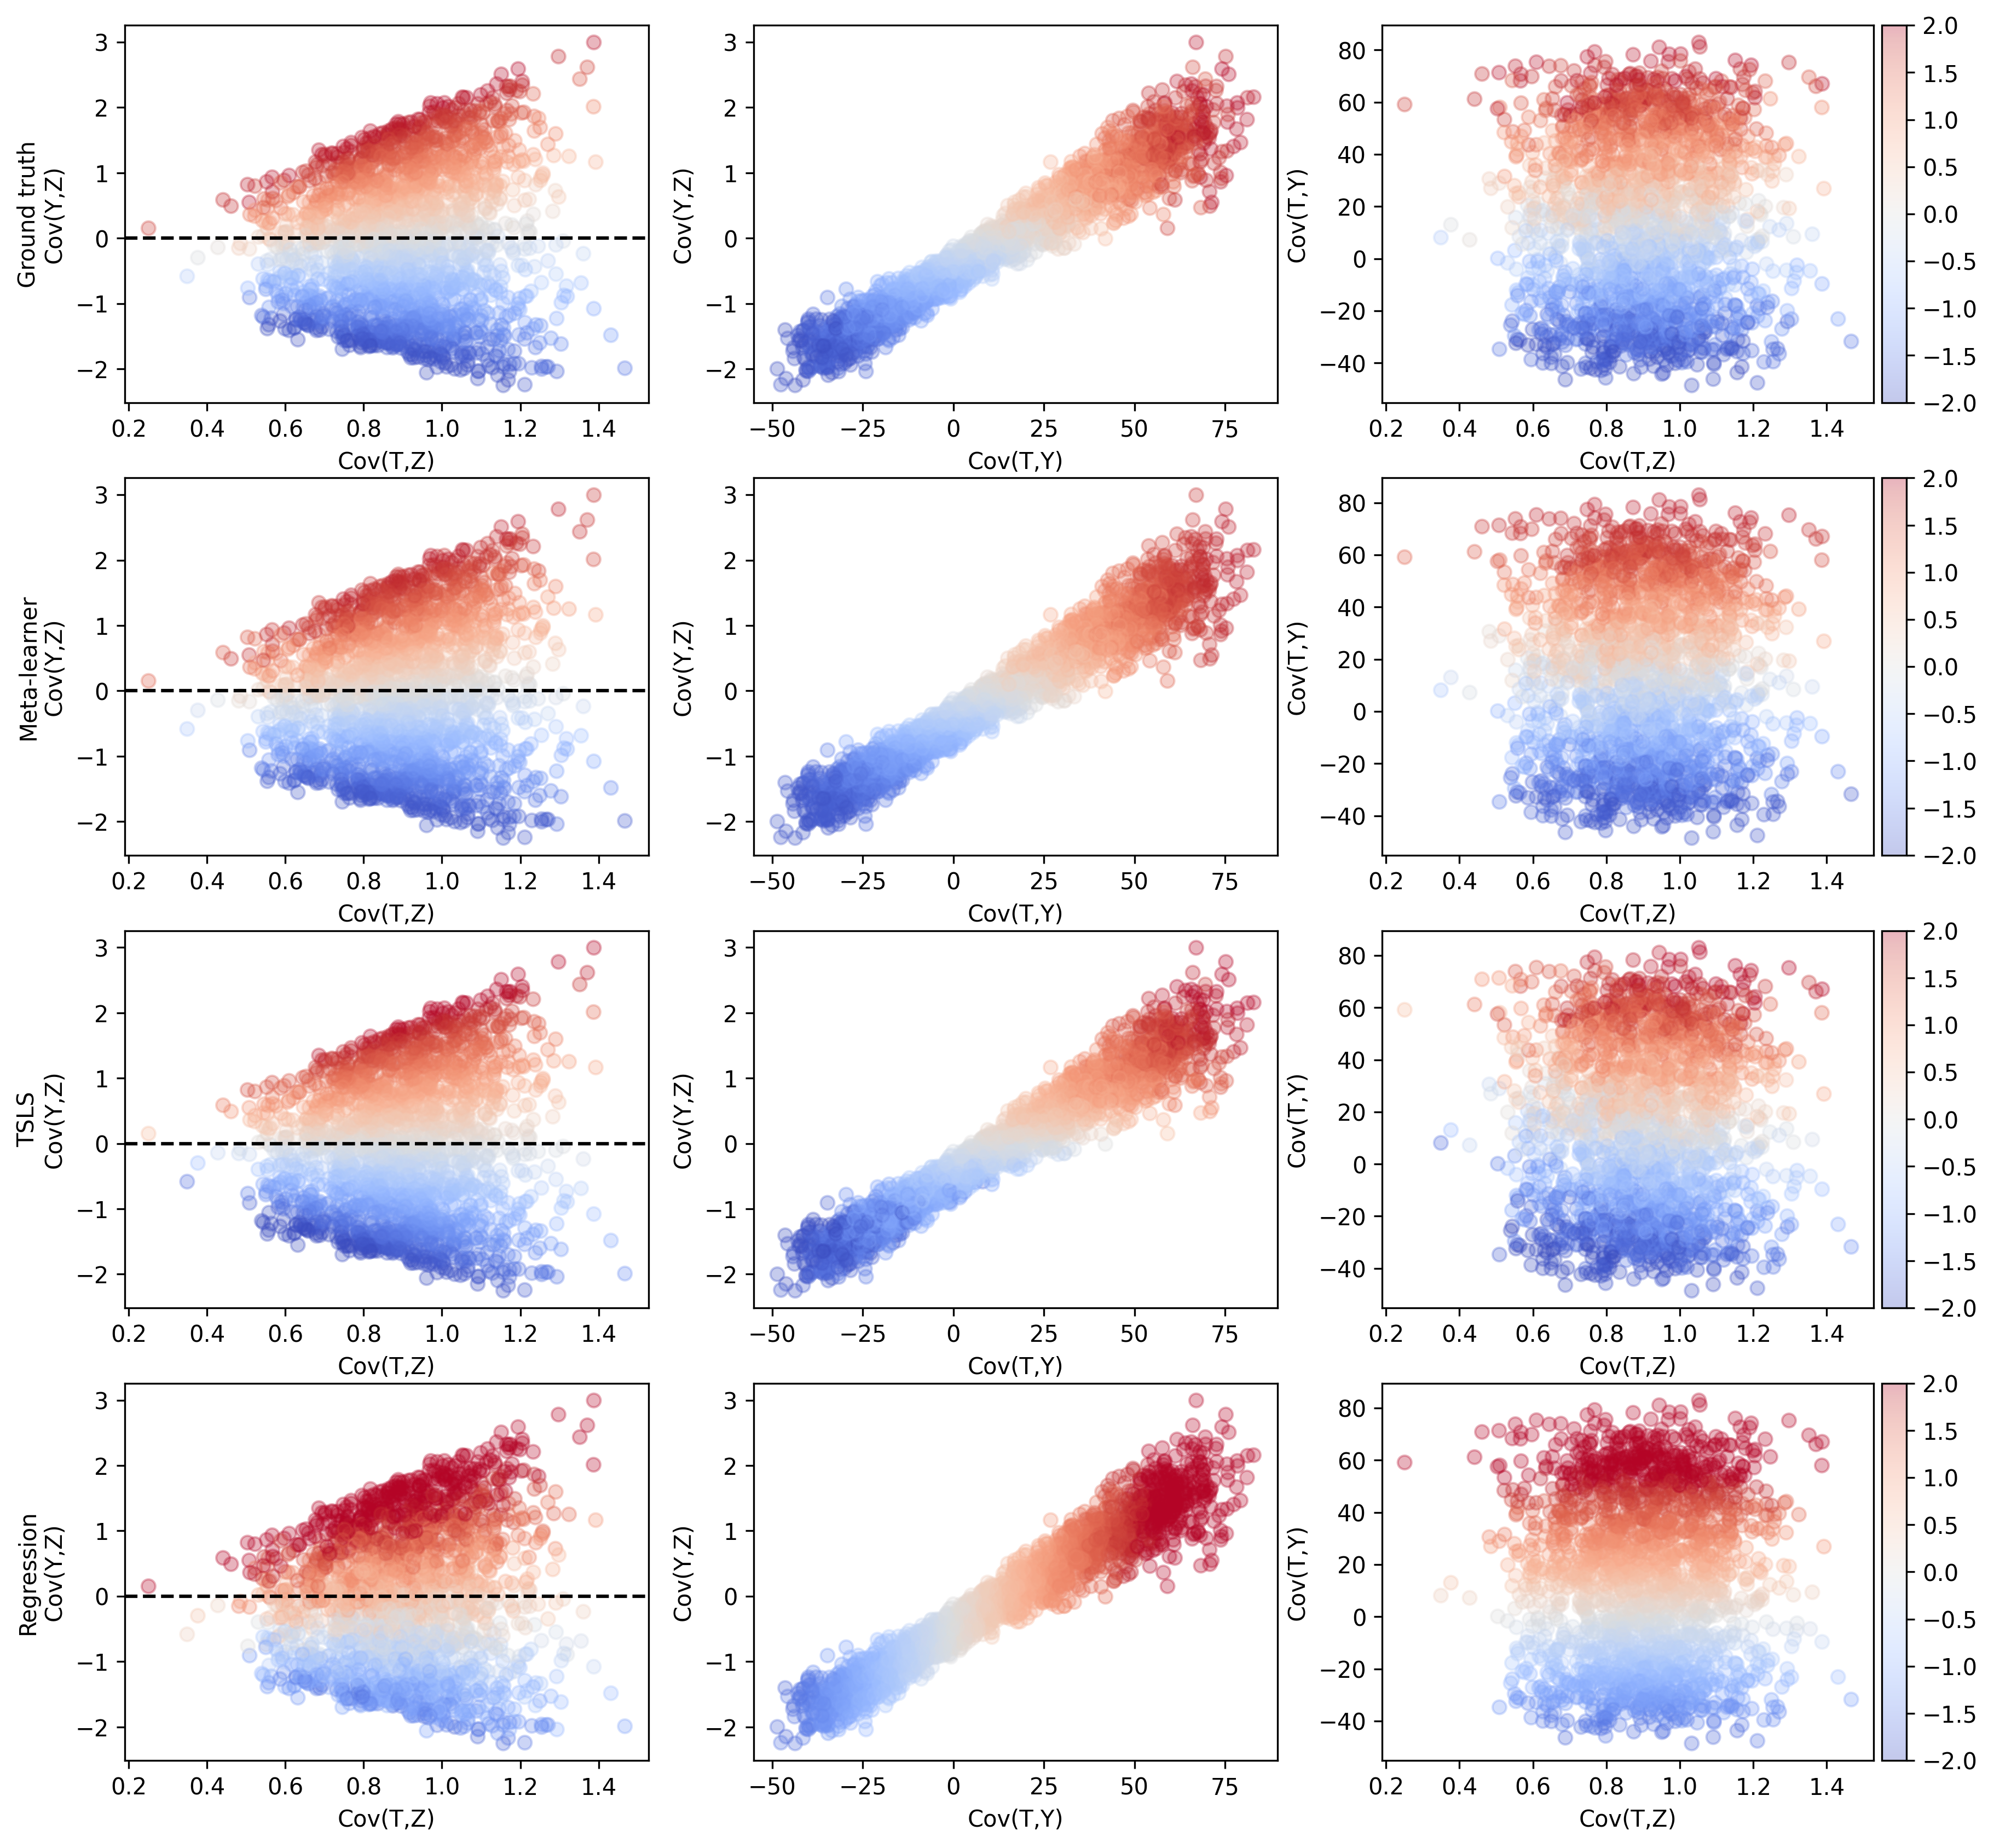

In [205]:
fig, axs = plt.subplots(4, 3, figsize=(14, 14), dpi=300)
fig.patch.set_color("white")
print(axs.shape)

COV_TY = 8
COV_YZ = 7
COV_TZ = 6

idx = -1

X_test = test_feats[idx]

# ground truth
ax1, ax2, ax3 = axs[0]
y = test_taus[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Ground truth\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# ml
ax1, ax2, ax3 = axs[1]
y = ml_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Meta-learner\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# tsls
ax1, ax2, ax3 = axs[2]
y = iv_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("TSLS\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# reg
ax1, ax2, ax3 = axs[3]
y = reg_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Regression\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")

ax1.axhline(y=0, ls='--', color='black')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

Text(0.5, 1.0, 'MSE for n=2000, confounded treatment, 10k datasets')

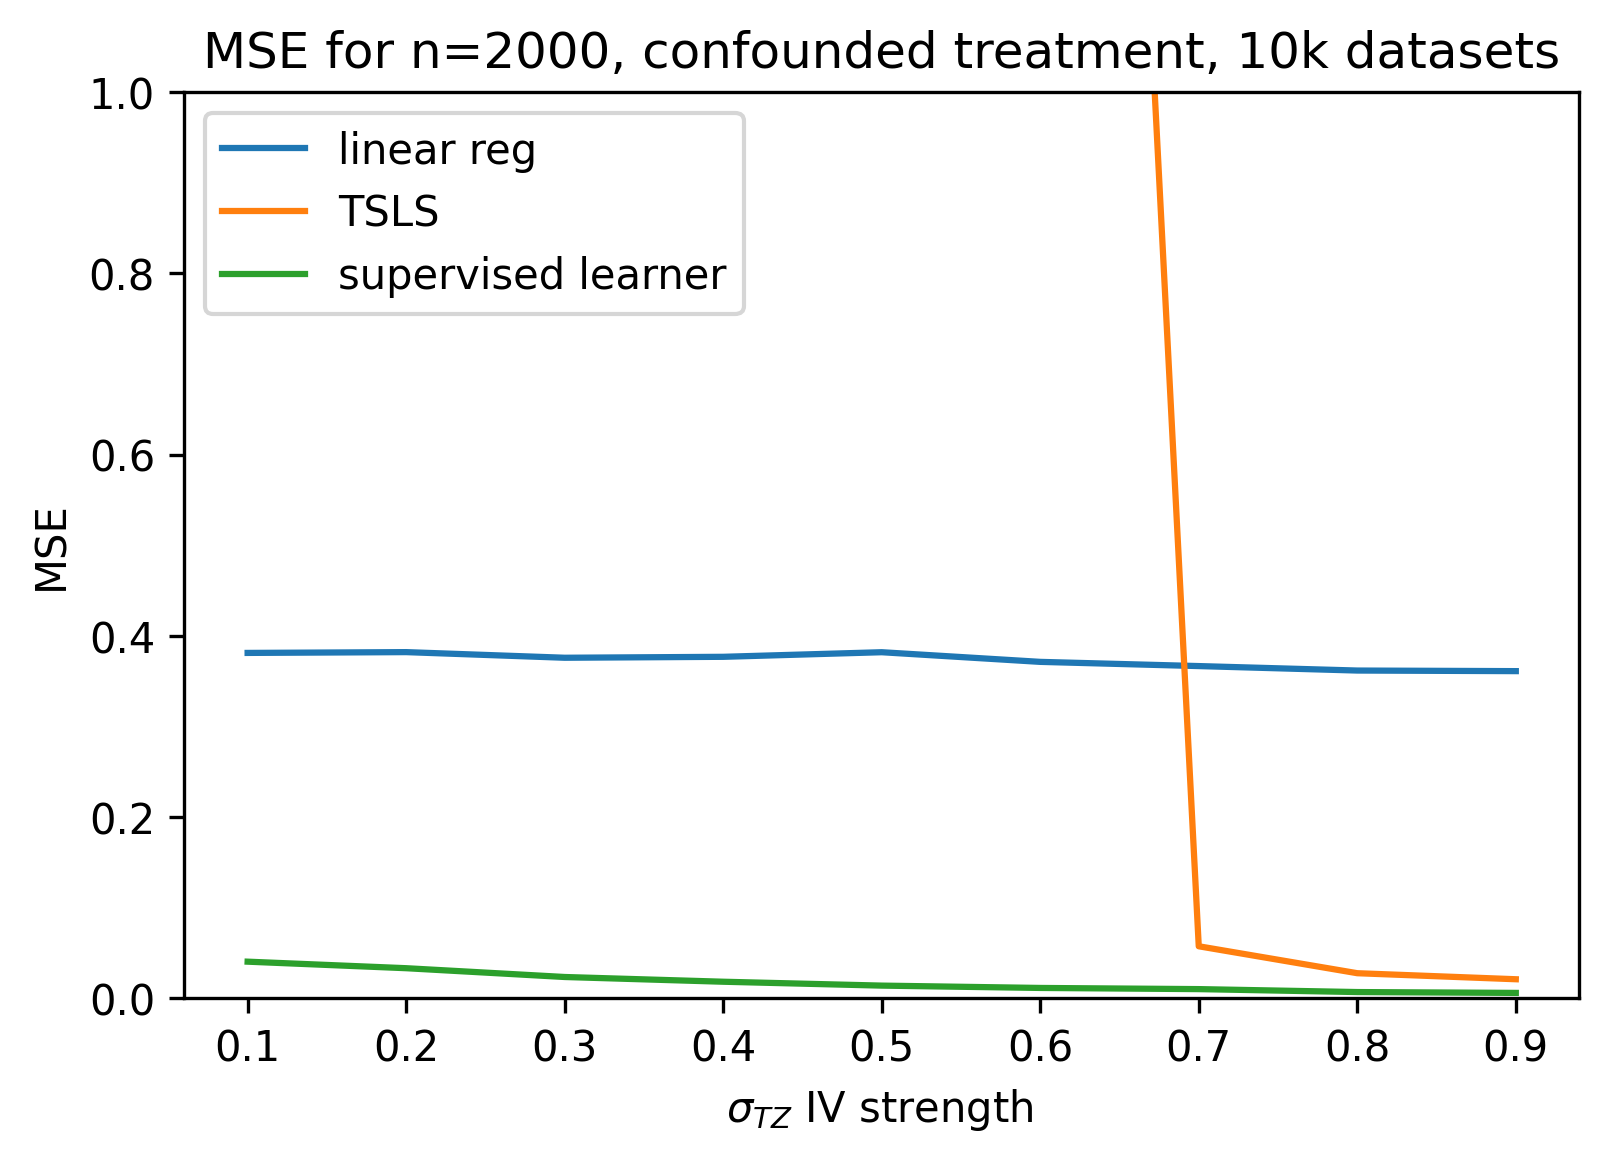

In [210]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_color("white")

ax.plot(iv_strs, reg_mses, label="linear reg")
ax.plot(iv_strs, iv_mses, label="TSLS")
ax.plot(iv_strs, ml_mses, label="supervised learner")
#ax.plot(iv_strs, wald_mses, label="Cov(Y,Z) / Cov(T,Z)")
ax.legend()
ax.set_ylim(0, 1)
ax.set_ylabel("MSE")
ax.set_xlabel("$\sigma_{TZ}$ IV strength ")
ax.set_title("MSE for n=2000, confounded treatment, 10k datasets")

In [228]:
pd.Series(feat_importances[5, :]).to_frame().style.format("{:.3f}")

Text(0.5, 1.0, 'MSE for n=2000, confounded treatment, 10k datasets')

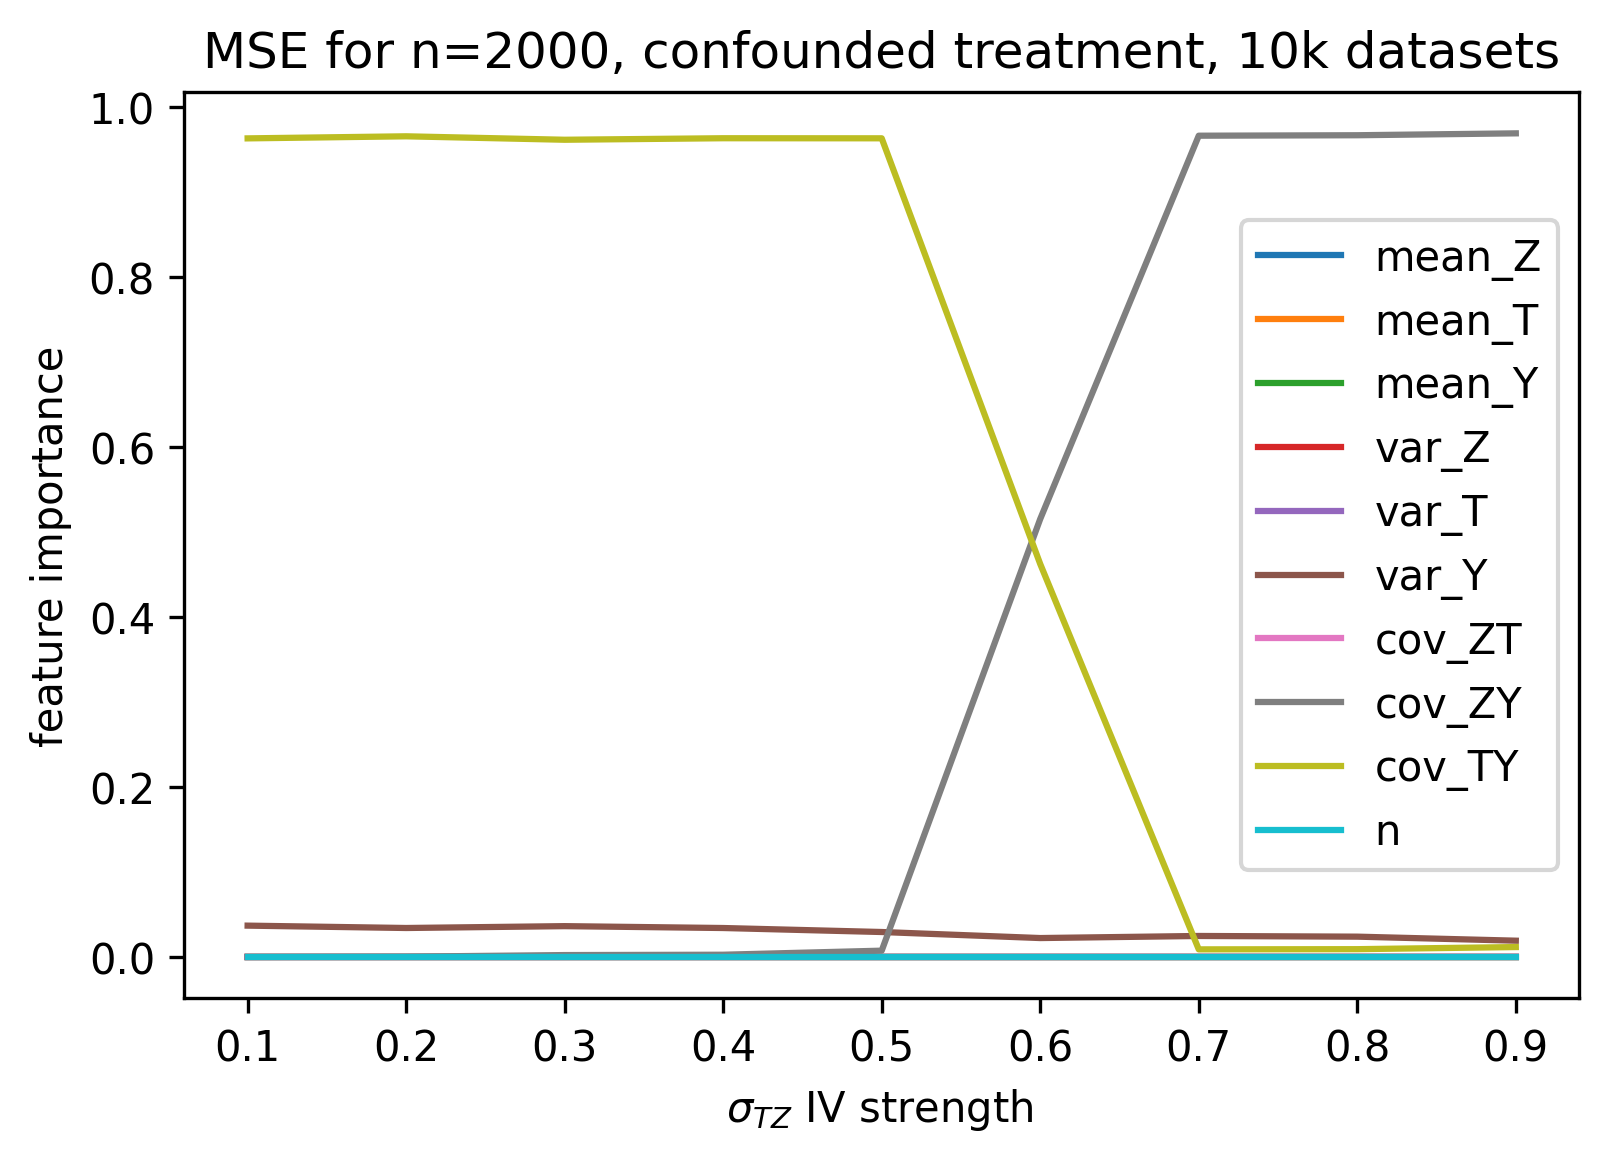

In [225]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_color("white")

for i in range(10):
    ax.plot(iv_strs, feat_importances[:, i], label=feat_cols[i])
ax.legend()
#ax.set_ylim(0, 1)
ax.set_ylabel("feature importance")
ax.set_xlabel("$\sigma_{TZ}$ IV strength ")
ax.set_title("MSE for n=2000, confounded treatment, 10k datasets")

# Setup: LATE